In [3]:
import os
import numpy as np
import torch
import json

In [4]:
# initialise arguments
adjective = 'naked'
seed = 0
root = f'../results/results_seed_{seed}/stable-diffusion/fine-tuned-relu/runwayml/stable-diffusion-v1-5/modularity/{adjective}/%s/%s'
timesteps = 51
n_layers = 16
num_experts_per_layer = [64, 64, 128, 128, 256, 256, 256, 256, 256, 256, 128, 128, 128, 64, 64, 64]

In [7]:
comparison_modes = ['skilled_expert_t_test', 'skilled_expert_moefy_compare']
comparison_names = ['t_test', 'moefy_compare']
ratios = [0.2, 0.2]
expert_for_modes = {}
all_modes_data = {}

for iter, mode in enumerate(comparison_modes):
    all_data = {}
    experts_all_t = np.zeros((timesteps))
    for t in range(timesteps):
        all_data[t] = {}
        experts_per_t = 0
        for l in range(n_layers):
            f_name = f'timestep_{t}_layer_{l}.json'
            experts = os.path.join(root % (mode, str(ratios[iter])), f_name)
            data = json.load(open(experts, 'r'))
            all_data[t][l] = data
            experts_per_t += len(data)
            print(f'Layer {l} at timestep {t} has {len(data)} experts')
        experts_all_t[t] = experts_per_t
        print(f'Timestep {t} has {experts_per_t} experts')
    expert_for_modes[mode] = experts_all_t
    all_modes_data[mode] = all_data


Layer 0 at timestep 0 has 17 experts
Layer 1 at timestep 0 has 39 experts
Layer 2 at timestep 0 has 59 experts
Layer 3 at timestep 0 has 69 experts
Layer 4 at timestep 0 has 124 experts
Layer 5 at timestep 0 has 145 experts
Layer 6 at timestep 0 has 53 experts
Layer 7 at timestep 0 has 126 experts
Layer 8 at timestep 0 has 89 experts
Layer 9 at timestep 0 has 119 experts
Layer 10 at timestep 0 has 96 experts
Layer 11 at timestep 0 has 73 experts
Layer 12 at timestep 0 has 84 experts
Layer 13 at timestep 0 has 50 experts
Layer 14 at timestep 0 has 44 experts
Layer 15 at timestep 0 has 34 experts
Timestep 0 has 1221 experts
Layer 0 at timestep 1 has 27 experts
Layer 1 at timestep 1 has 51 experts
Layer 2 at timestep 1 has 103 experts
Layer 3 at timestep 1 has 100 experts
Layer 4 at timestep 1 has 199 experts
Layer 5 at timestep 1 has 180 experts
Layer 6 at timestep 1 has 98 experts
Layer 7 at timestep 1 has 179 experts
Layer 8 at timestep 1 has 151 experts
Layer 9 at timestep 1 has 178 e

FileNotFoundError: [Errno 2] No such file or directory: '../results/results_seed_0/stable-diffusion/fine-tuned-relu/runwayml/stable-diffusion-v1-5/modularity/naked/skilled_expert_t_test_expert/0.2/timestep_0_layer_0.json'

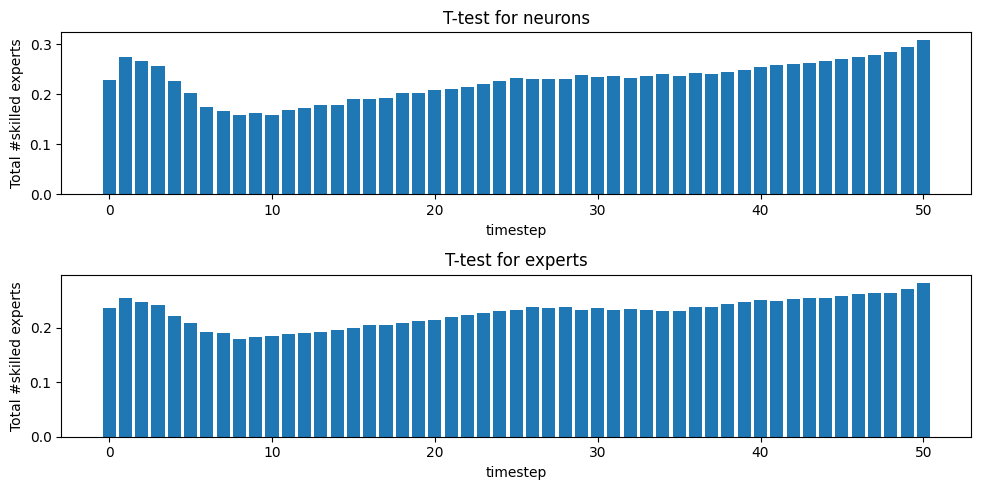

In [63]:
# plot experts per timestep in a bar plot
plot_titles = {}
plot_titles['skilled_expert_t_test_expert'] = 'T-test for experts'
plot_titles['skilled_expert_moefy_compare'] = 'Selection Frequency'
plot_titles['skilled_expert_t_test'] = 'T-test for neurons'
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, figsize=(10, 5))
for i, mode in enumerate(comparison_modes):
    ax[i].bar(np.arange(timesteps), expert_for_modes[mode]/sum(num_experts_per_layer), label=comparison_names[i])
    ax[i].set_title(plot_titles[mode])
    ax[i].set_xlabel('timestep')
    ax[i].set_ylabel('Total #skilled experts')
    
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Difference in #experts')

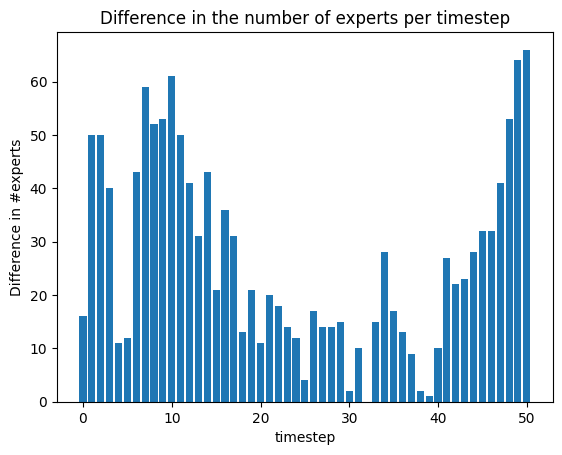

In [64]:
# Plot the difference in experts for every expert
expert_len_diff = np.zeros((timesteps))
for t in range(timesteps):
    expert_len_diff[t] += abs(expert_for_modes[comparison_modes[0]][t] - expert_for_modes[comparison_modes[1]][t])
plt.bar(np.arange(timesteps), expert_len_diff)
plt.title('Difference in the number of experts per timestep')
plt.xlabel('timestep')
plt.ylabel('Difference in #experts')

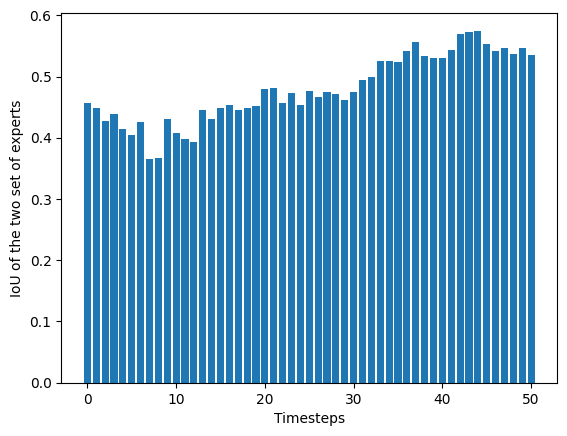

In [65]:
# get intersection of experts for the two different methods for each timestep and each layer
intersection = np.zeros((timesteps)) 
for t in range(timesteps):
    for l in range(n_layers):
        set1 = set(all_modes_data[comparison_modes[0]][t][l])
        set2 = set(all_modes_data[comparison_modes[1]][t][l])
        if len(set1.union(set2)) > 0:
            intersection[t] += len(set1.intersection(set2)) / len(set1.union(set2))
        else:
            intersection[t] += 0

    intersection[t] /= n_layers

# plot the intersection of experts for each timestep and each layer
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.bar(range(timesteps), intersection)
ax.set_xlabel('Timesteps')
ax.set_ylabel('IoU of the two set of experts')
plt.show()

In [70]:
# Save the intersection of experts in a folder for further analysis
dir_name = f'../results/results_seed_{seed}/stable-diffusion/fine-tuned-relu/runwayml/stable-diffusion-v1-5/modularity/{adjective}/%s/' %  ('skilled_expert_'+'_'.join(comparison_names))
print(dir_name)
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

ratio = '_'.join([str(r) for r in ratios])
dir_name = os.path.join(dir_name, f'{ratio}')
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

save_intersection = {}
for t in range(timesteps):
    save_intersection[t] = {}
    for l in range(n_layers):
        save_intersection[t][l] = list(set(all_modes_data[comparison_modes[0]][t][l]).intersection(set(all_modes_data[comparison_modes[1]][t][l])))
        json.dump(save_intersection[t][l], open(os.path.join(dir_name, f'timestep_{t}_layer_{l}.json'), 'w'))

# os.makedirs(os.path.join(dir_name, 'remove_experts'))
# os.makedirs(os.path.join(dir_name, 'remove_experts_val'))

../results/results_seed_0/stable-diffusion/fine-tuned-relu/runwayml/stable-diffusion-v1-5/modularity/under a tree/skilled_expert_t_test_t_test_expert/


[5, 15, 25, 35, 45]
2496


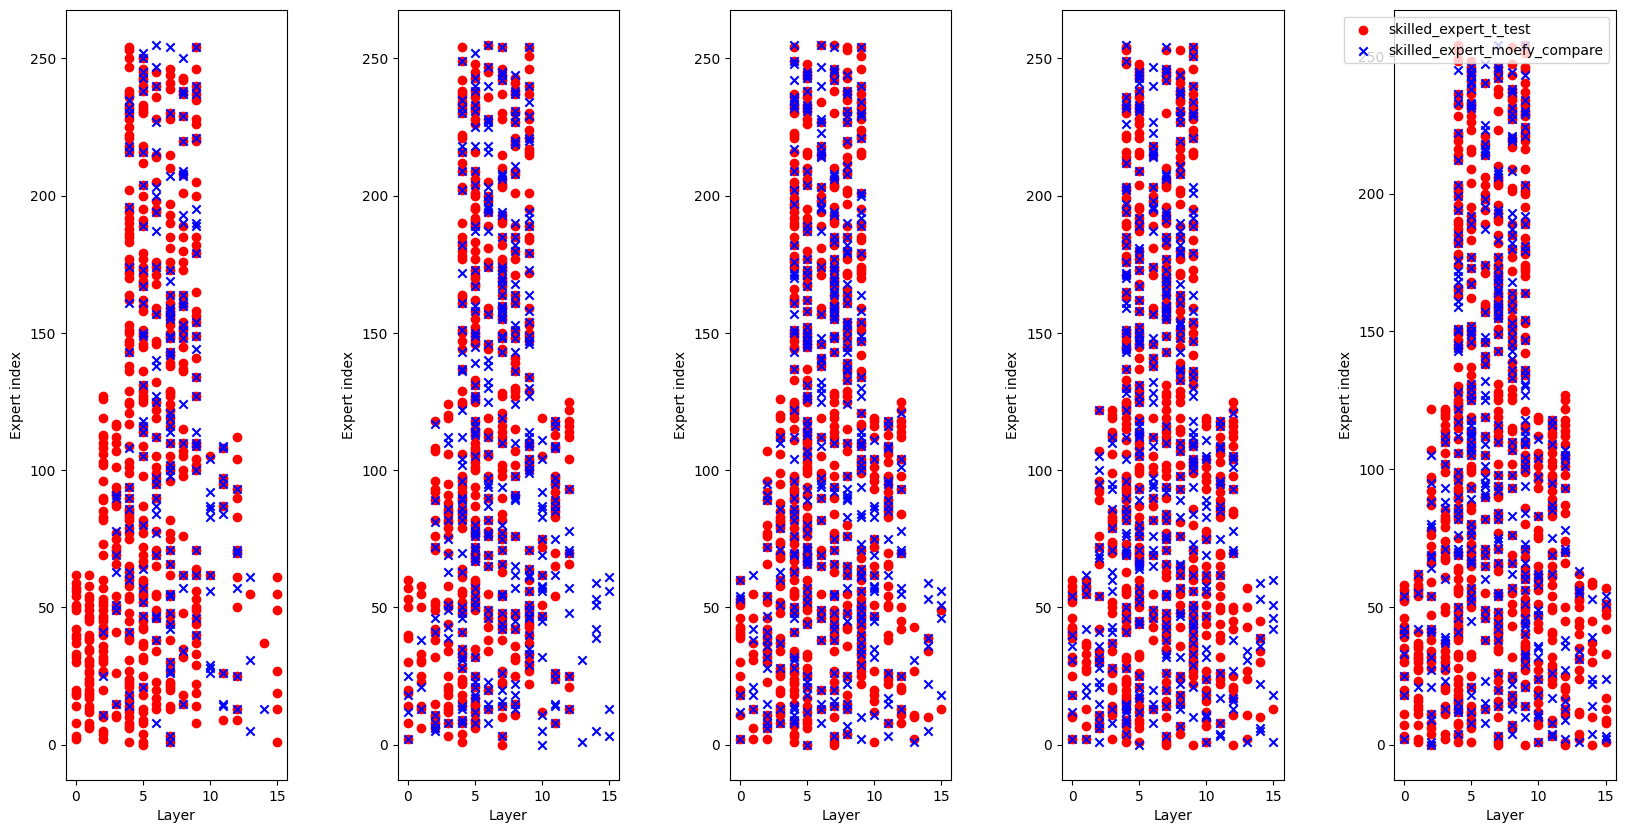

In [83]:
T = np.arange(5, timesteps, 10).tolist()
print(T)
# number of experts in each layer
num_experts_per_layer = [64, 64, 128, 128, 256, 256, 256, 256, 256, 256, 128, 128, 128, 64, 64, 64]
print(sum(num_experts_per_layer))


fig, axes = plt.subplots(1, 5, figsize=(20, 10))
# hspace and wspace are the amounts of width reserved for space between subplots, expressed as a fraction of the average axis width.
plt.subplots_adjust(hspace=0.5, wspace=0.5)

markers = ['o', 'x']
# mark skilled experts found by both comparison modes in the same layer with different markers
for iter, t in enumerate(T):
    ax = axes[iter%5]
    for l in range(n_layers):
        experts1 = all_modes_data[comparison_modes[0]][t][l]
        experts2 = all_modes_data[comparison_modes[1]][t][l]
        if l == 0:
            ax.scatter([l]*len(experts1), experts1, marker=markers[0], color='r', label='skilled_expert_t_test')
            ax.scatter([l]*len(experts2), experts2, marker=markers[1], color='b', label='skilled_expert_moefy_compare')
        else:
            ax.scatter([l]*len(experts1), experts1, marker=markers[0], color='r')
            ax.scatter([l]*len(experts2), experts2, marker=markers[1], color='b')
    ax.set_xlabel('Layer')
    ax.set_ylabel('Expert index')
plt.legend()
plt.show()
    